[header stuff here]


# **01: EDA**
---

Start by importing a few important libraries:

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from datetime import datetime

# Import Augmented Dickey-Fuller test.
from statsmodels.tsa.stattools import adfuller

## First we'll check out the **target data**. We want to check for a few things:
* Do the data exhibit trends over time? Is there stationarity?
    * To check, we can run each series through the augmented Dickey-Fuller test to determine if we can reject the Null Hypothesis H0 that there is no stationarity.
* Do the data exhibit seasonality over time?


In [3]:
crime = pd.read_csv('../data/model_inputs/predictors_and_targets.csv')

In [4]:
crime.head()

,state_abbr,year,population,violent_crime,homicide,rape,robbery,aggravated_assault,property_crime,burglary,...,burglary_1000,larceny_1000,motor_vehicle_theft_1000,arson_1000,avg_unemployment_rate,avg_CPI,ag_Democrat,ag_Mixed,ag_Republican,ag_Unknown
0,AL,1979,3769000,15578,496,1037,4127,9918,144372,48517,...,12.872645,22.231626,3.200849,0.067392,7.225000,72.583333,1,0,0,0
1,AL,1980,3861466,17320,509,1158,5102,10551,173191,58952,...,15.266741,26.422348,3.162012,0.287197,8.816667,82.383333,1,0,0,0
2,AL,1981,3916000,18423,465,1021,4952,11985,173411,56811,...,14.507406,26.933350,2.841931,0.305158,10.691667,90.933333,1,0,0,0
3,AL,1982,3943000,17653,417,1026,4417,11793,165048,49531,...,12.561755,26.563530,2.733198,0.273396,13.950000,96.533333,1,0,0,0
4,AL,1983,3959000,16471,364,931,3895,11281,145890,42485,...,10.731245,23.813842,2.305128,0.247790,13.816667,99.583333,1,0,0,0


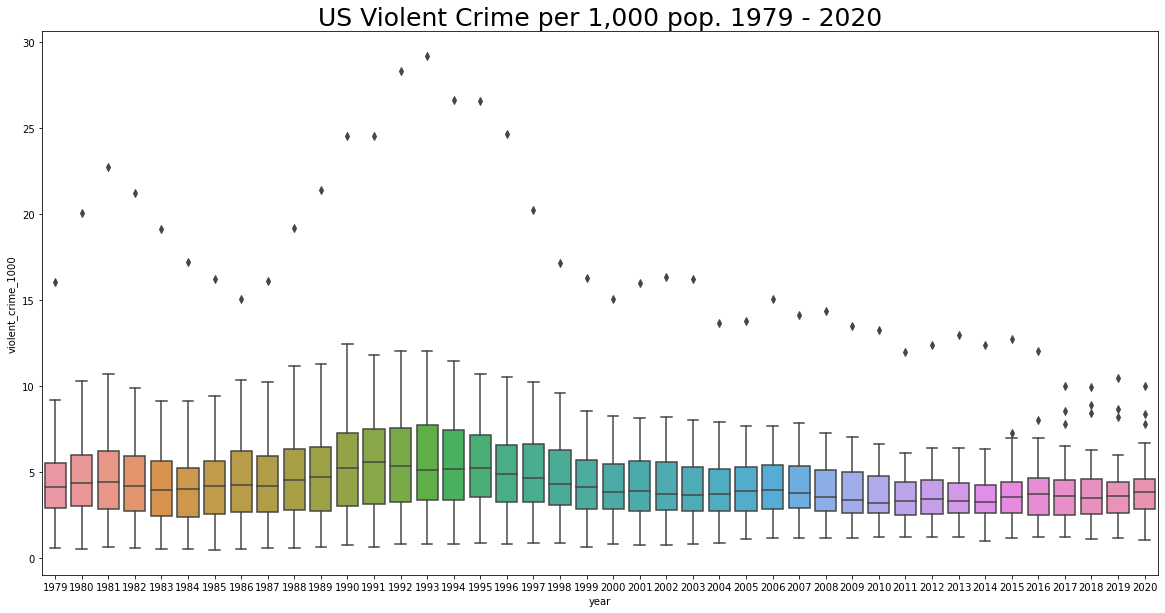

In [5]:
plt.figure(figsize=(20,10))
plt.title(f'US Violent Crime per 1,000 pop. {min(crime["year"])} - {max(crime["year"])}', size = 25)
sns.boxplot(x='year',
            y=crime['violent_crime_1000'],
            data=crime);

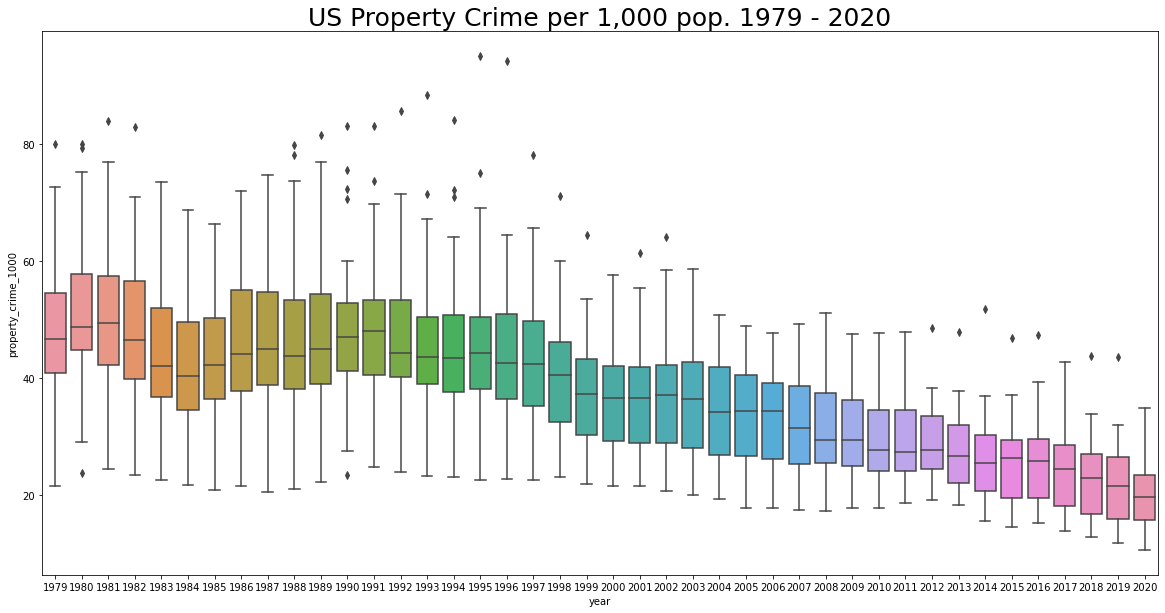

In [6]:
plt.figure(figsize=(20,10))
plt.title(f'US Property Crime per 1,000 pop. {min(crime["year"])} - {max(crime["year"])}', size = 25)
sns.boxplot(x='year',
            y=crime['property_crime_1000'],
            data=crime);

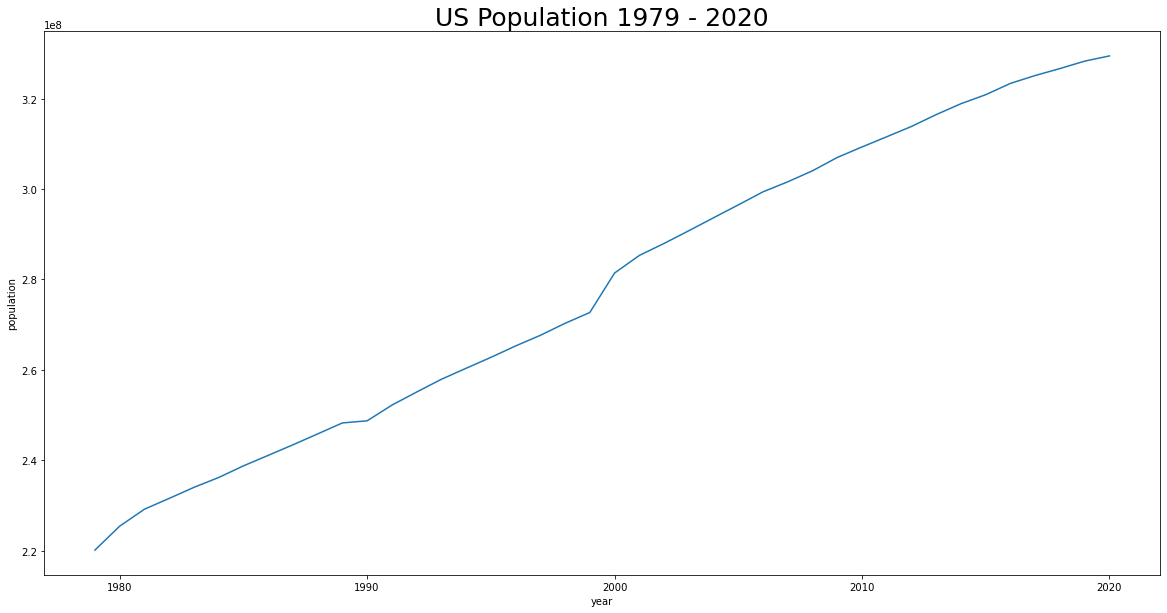

In [7]:
plt.figure(figsize=(20,10))
plt.title(f'US Population {min(crime["year"])} - {max(crime["year"])}', size = 25)
sns.lineplot(x=crime.groupby('year')['population'].sum().index, 
             y=crime.groupby('year')['population'].sum());

Based on the above 3 plots, we can see the following **at the National level**:
* Violent crime per 1,000 population doesn't appear to exhibit any seasonality or trend over the timeframe.
    * This is despite a consistent rise in population between 1979 and 2020.
* Property crime per 1,000 population doesn't appear to exhibit any seasonality, but appears to trend downward over time.
    * This is likely attributable to growth in population.
    
The plot below can show us the directionality of raw property crime counts over time at the National level:

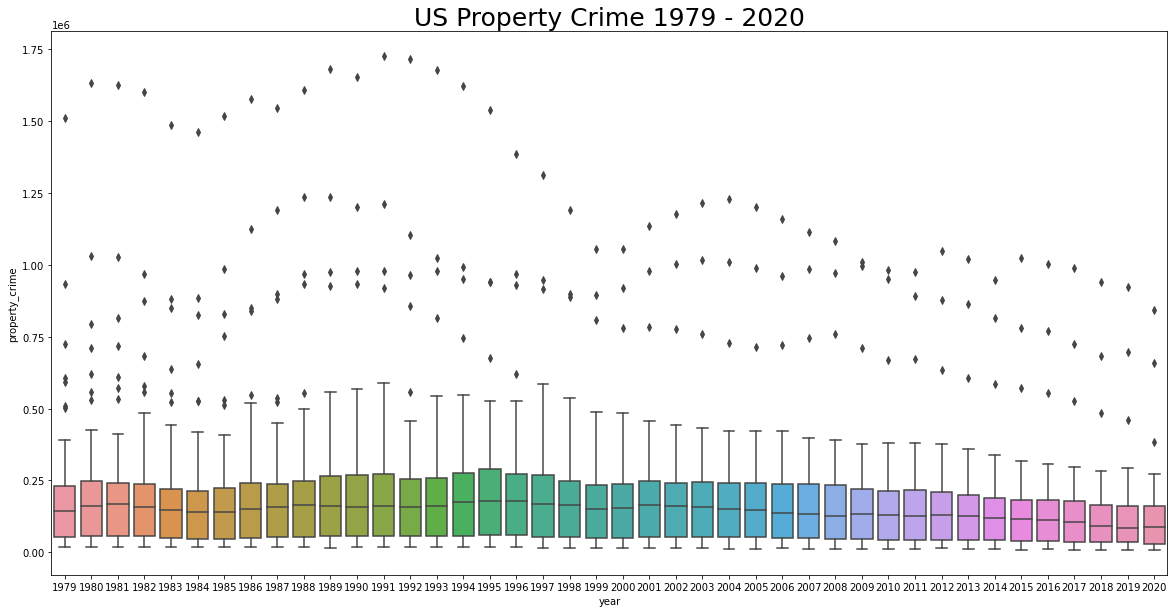

In [8]:
plt.figure(figsize=(20,10))
plt.title(f'US Property Crime {min(crime["year"])} - {max(crime["year"])}', size = 25)
sns.boxplot(x='year',
            y=crime['property_crime'],
            data=crime);

Still no apparent seasonality in raw property crime counts at the national level. Mean state property crime does appear to be trending downward, if only slightly. Further, annual property crime counts in states at the 75% quantile seems to trend downward from the late-90s onward.

For completeness, let's also view the same timeline for raw violent crime counts:

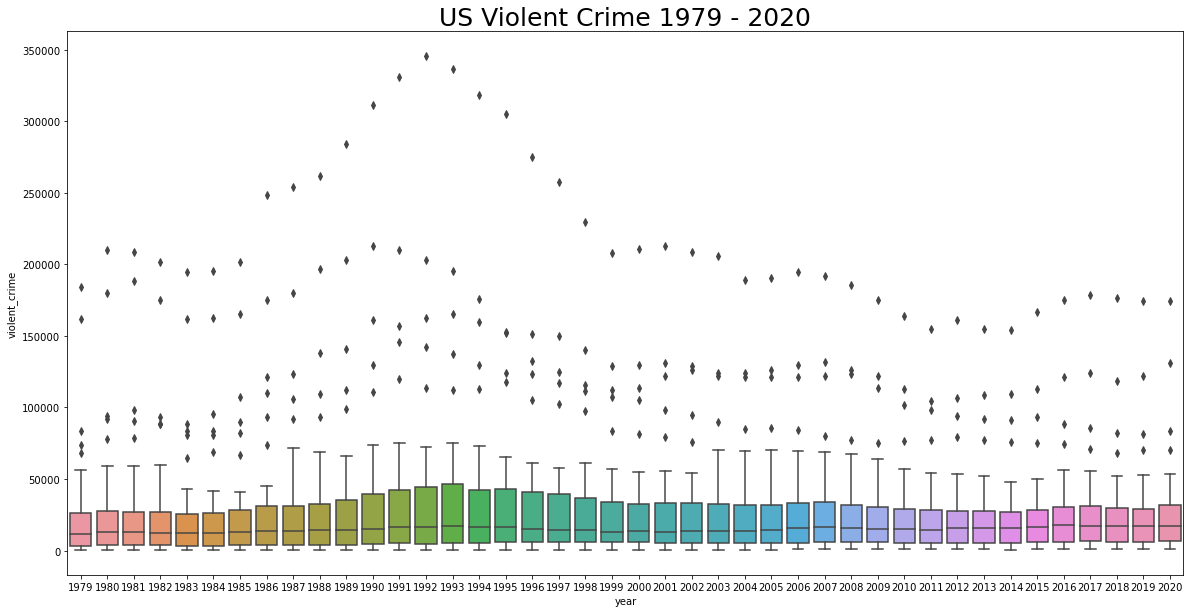

In [9]:
plt.figure(figsize=(20,10))
plt.title(f'US Violent Crime {min(crime["year"])} - {max(crime["year"])}', size = 25)
sns.boxplot(x='year',
            y=crime['violent_crime'],
            data=crime);

Not seeing any obvious trends or seasonality in the above. However, the distribution of violent crime outlier states seems to get more condense over time.

---

## Let's look a little closer at the state level

Define a function below that charts each state's violent crime and property crime in two stacked subplots:

In [10]:
# legend placement code inspired by ImportanceOfBeingErnest: https://stackoverflow.com/a/43439132

def print_crime_timeplots(state, mode):
    """Pass a state (two-digit code) and a mode: 0 - Violent Crimes, 1 - Property Crimes"""
    category = 'violent_crime' if mode == 0 else 'property_crime'
    with sns.axes_style("darkgrid"):
        my_figsize=(16,8)
        df = crime.copy()
        df = df[df['state_abbr'] == state]
        df['pop%'] = df['population']/df['year'].map(lambda x: np.sum(crime[crime['year']==x]['population']))
        if mode == 0:
            components = ['homicide','rape','robbery','aggravated_assault']
        else:
            components = ['burglary','larceny', 'motor_vehicle_theft', 'arson']
        minyear = min(df['year'])
        maxyear = max(df['year'])
        
        #set subplots configuration:
        fig, axs = plt.subplots(nrows=2,
                                ncols=2,
                                figsize=my_figsize)
        #add plots:
        #components
        for i, cat in enumerate(components):
            sns.lineplot(x=df['year'], y=df[components[i]],label=components[i], ax=axs[0,0])
        
        #categories
        sns.lineplot(x=df['year'],y=df[category], label=category, ax=axs[1,0])
        
        #State population
        sns.lineplot(x=df['year'],y=df['population'], label='population',ax=axs[0,1])
        
        #% of national
        sns.lineplot(x=df['year'],y=df['pop%'], label='% of national population', ax=axs[1,1])
        
        #style chart:
        fig.suptitle(f'{state} {category.replace("_"," ").title()} Components {minyear} - {maxyear}', y = 1, fontsize=20)
        axs[0,0].set(ylabel=f'{category.replace("_"," ").title()}\ncomponents')
        axs[1,0].set(ylabel=f'{category.replace("_"," ").title()}\nTotal')

        axs[0,1].set(ylabel=f'{state}\nPopulation')
        axs[1,1].set(ylabel=f'{state}% of\nNational Population')
        
        axs[0,0].legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=4)
        
        plt.show()

It'd probably be too much view these plots for every state, but maybe we can look at the timeplots for those states which had the highest crime rates per 1,000 population in the last year.

In [11]:
violent_1000_rank_latest = crime[crime['year']==max(crime['year'])].groupby('state_abbr')['violent_crime_1000'].sum().sort_values()
least_violent = violent_1000_rank_latest[:3]
most_violent = violent_1000_rank_latest[-3:].sort_values(ascending=False)

In [12]:
least_violent

state_abbr
ME    1.085813
NH    1.463834
VT    1.734187
Name: violent_crime_1000, dtype: float64

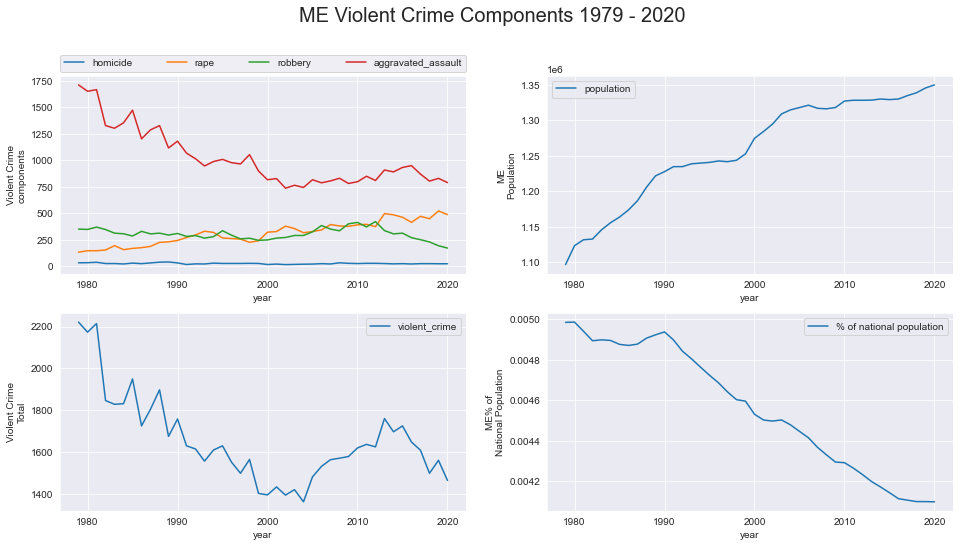

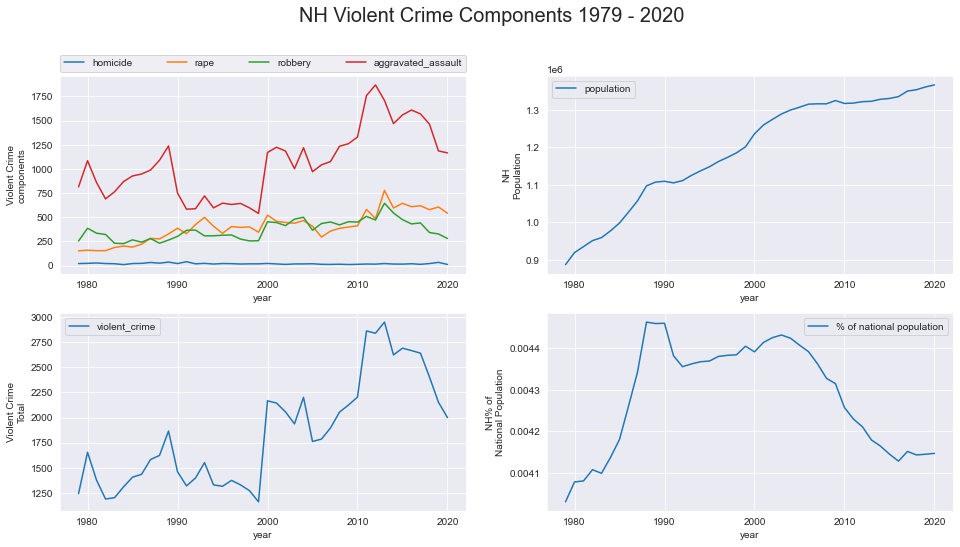

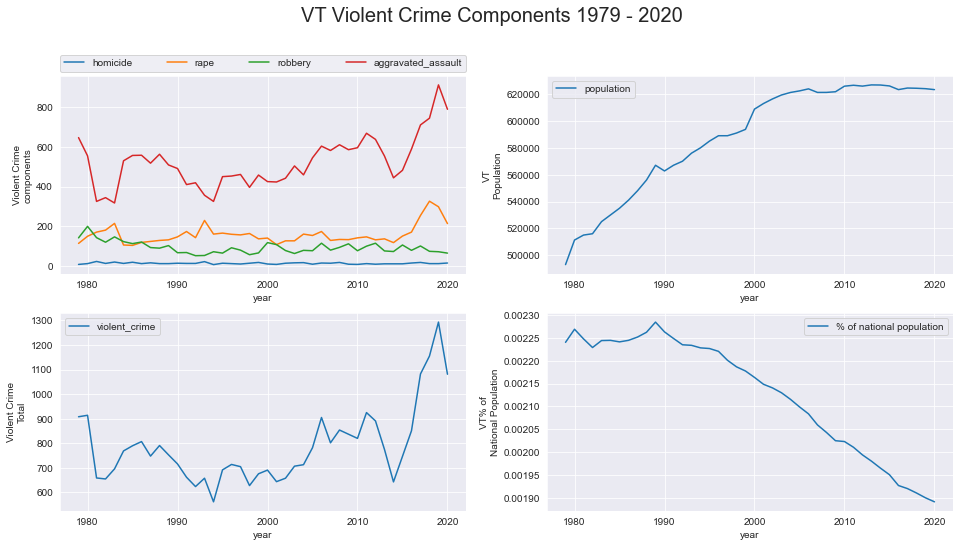

In [13]:
for state in least_violent.index:
    print_crime_timeplots(state, 0)

Among the three least violent states, we can see a few common patterns:
* Population tends to grow over time.
* Aggravated assaults are the most common violent crimes and homicides are the least.
* State population as a proportion of National population tends to decrease in the latest years.
    * New Hampshire's share of national population grew sharply in the 80s, roughly plateaued and then began to fall in the mid 2000s.

---

Let's look at the same timeplots for the most violent states:

In [14]:
most_violent

state_abbr
DC    9.998373
AK    8.378490
NM    7.782772
Name: violent_crime_1000, dtype: float64

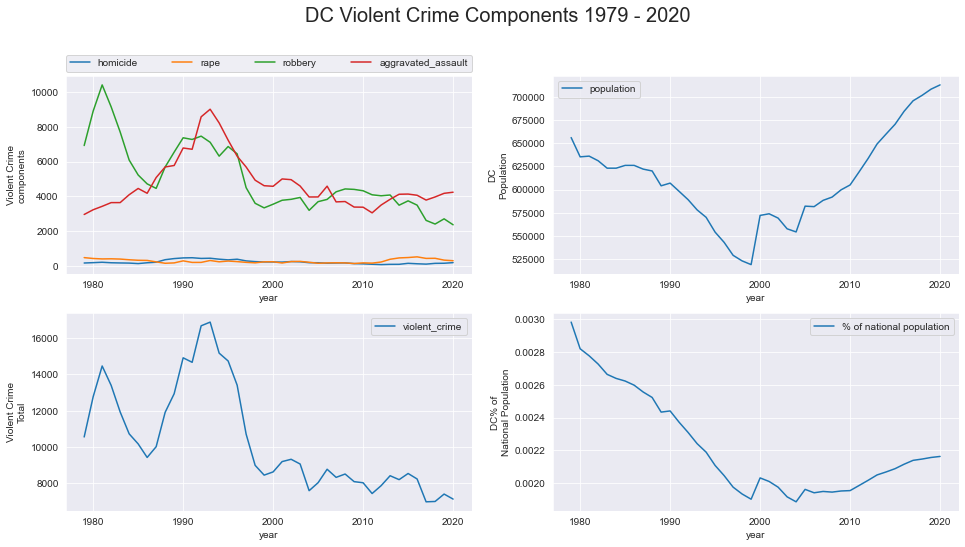

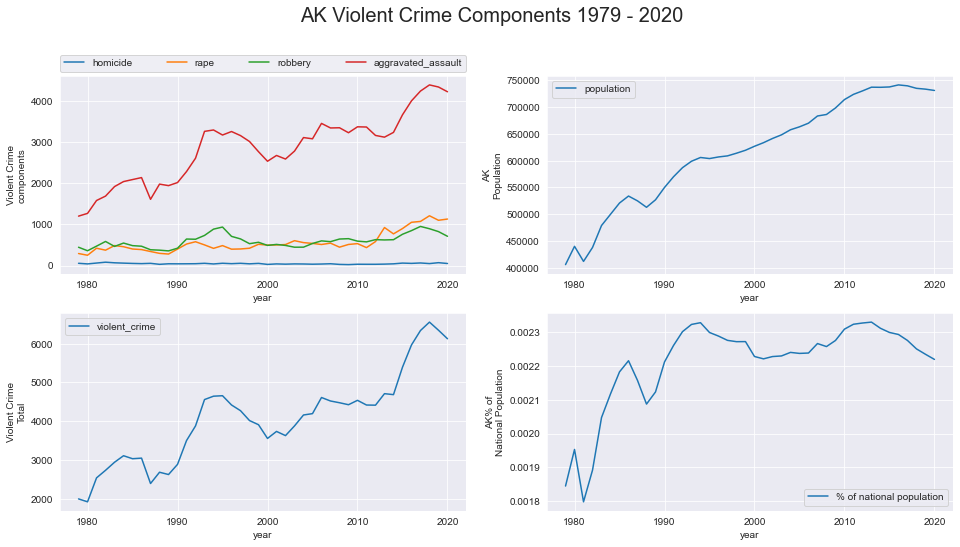

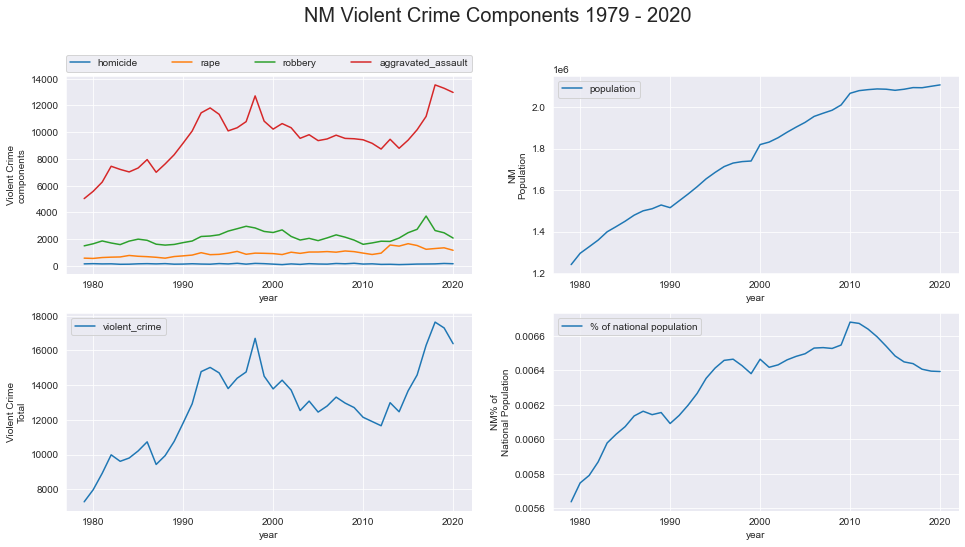

In [15]:
for state in most_violent.index:
    print_crime_timeplots(state,0)


---

Let's conduct the same analyses for property crime.

In [16]:
property_1000_rank_latest = crime[crime['year']==max(crime['year'])].groupby('state_abbr')['property_crime_1000'].sum().sort_values()
least_property = property_1000_rank_latest[:3]
most_property = property_1000_rank_latest[-3:].sort_values(ascending=False)

In [17]:
least_property #property crimes per 1000 population in latest year

state_abbr
MA    10.531837
NH    10.989003
ID    11.118756
Name: property_crime_1000, dtype: float64

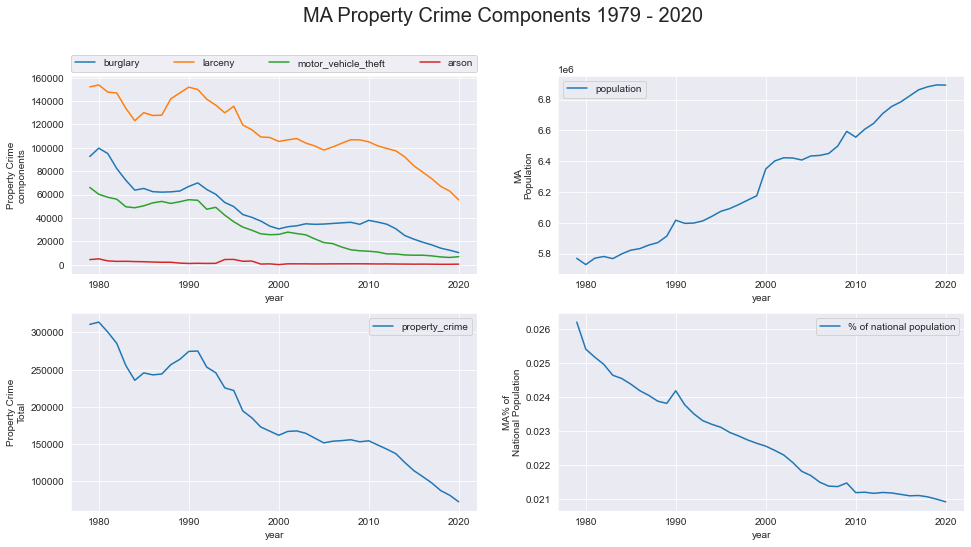

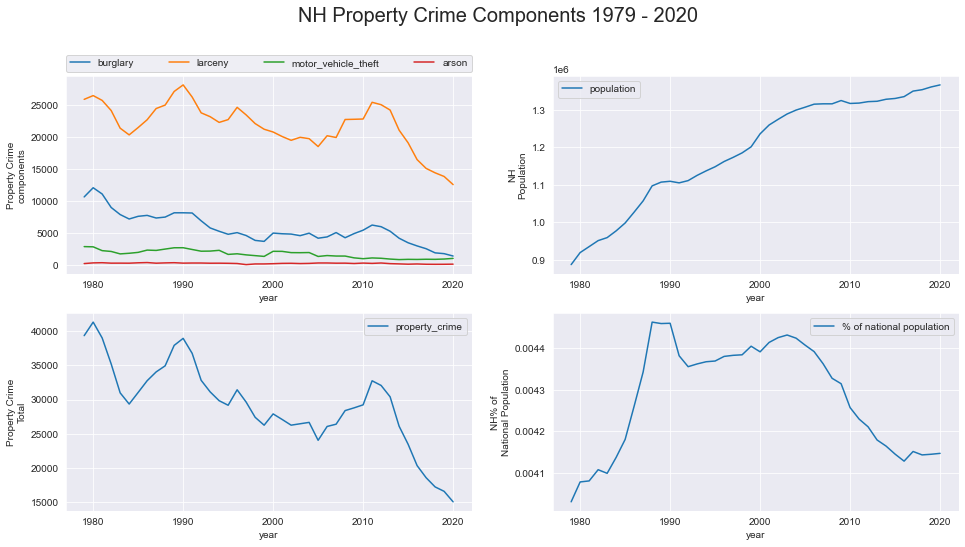

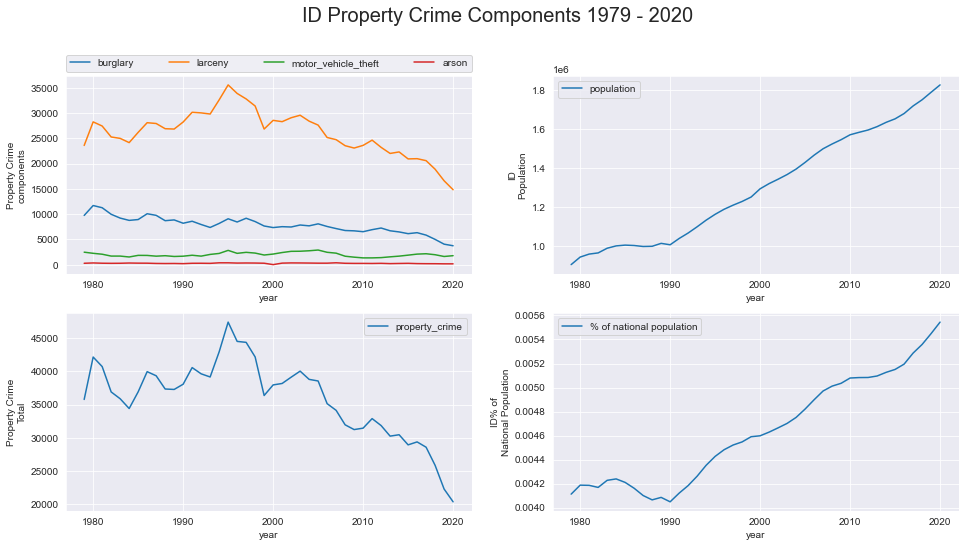

In [18]:
for state in least_property.index:
    print_crime_timeplots(state, 1)

In [19]:
most_property #property crimes per 1000 population in latest year

state_abbr
DC    34.930473
LA    28.843881
NM    28.418772
Name: property_crime_1000, dtype: float64

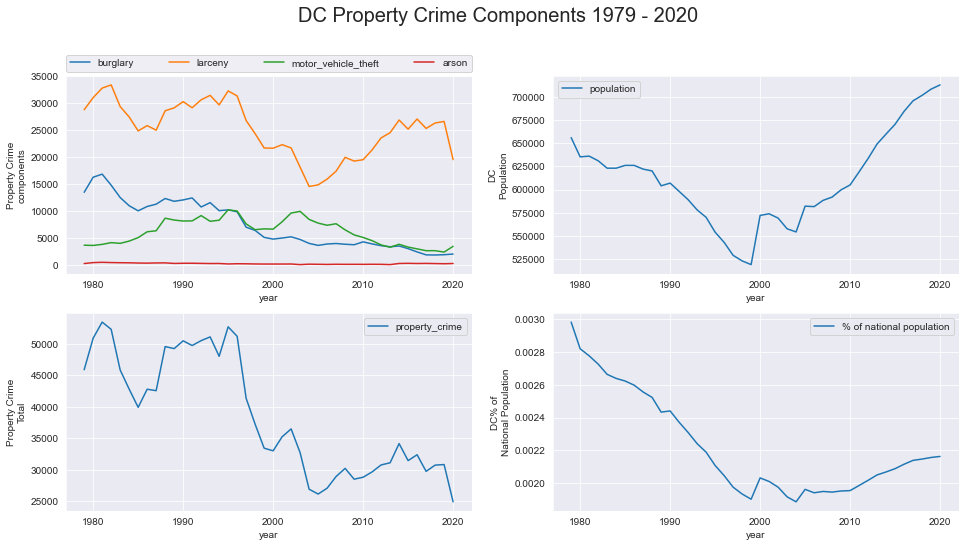

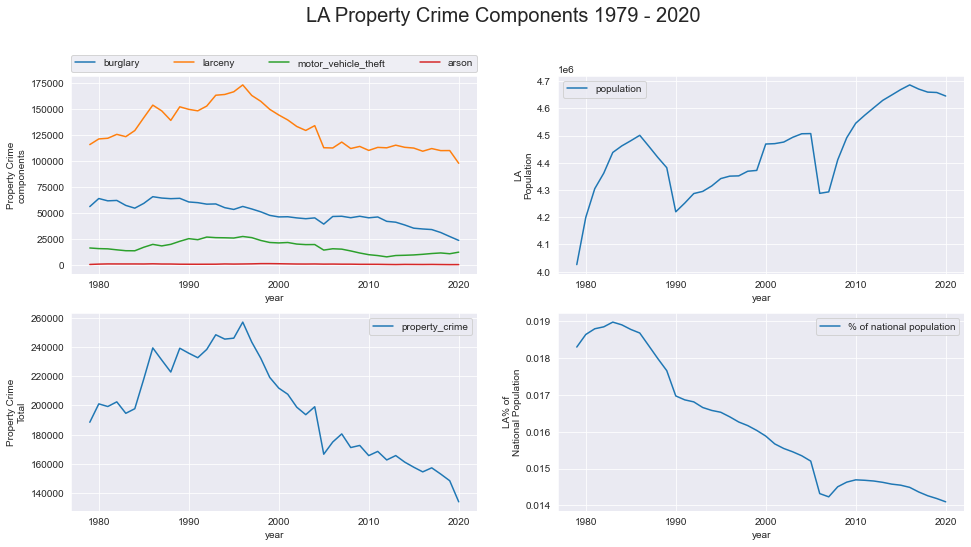

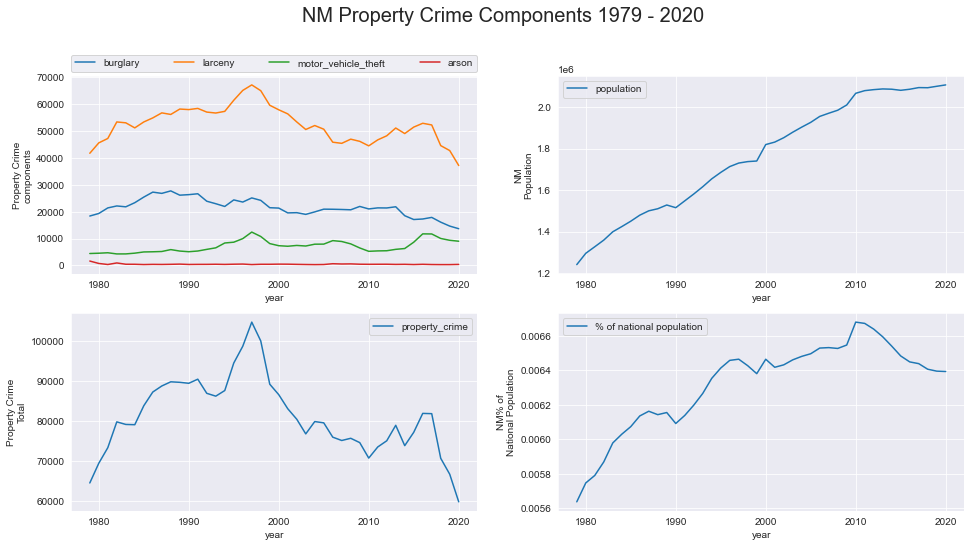

In [20]:
for state in most_property.index:
    print_crime_timeplots(state, 1)



---

## Checking for stationarity
For each state, let's determine if the timeplots for `violent_crime_1000` and `property_crime_1000` exhibit stationarity. We'll do an augmented Dickey-Fuller test for each state and time series (51 * 2 = 102 times) and render `stationary = 0` if p < a else `stationary = 1`.

For this analysis, we'll set an **alpha of 0.05**.

In [21]:
def get_stationarity(state, crime_category):
    df = crime.copy()
    df = df[df['state_abbr']==state][crime_category]
    alpha=0.05
    p = adfuller(df)[1]
    return 1 if p < alpha else 0

In [22]:
stationarity = pd.DataFrame(crime['state_abbr'].unique(),columns=['state'])

In [23]:
stationarity['violent_stationarity'] = stationarity['state'].map(lambda x: get_stationarity(x, 'violent_crime_1000'))
stationarity['property_stationarity'] = stationarity['state'].map(lambda x: get_stationarity(x, 'property_crime_1000'))

In [24]:
print(f'{stationarity["violent_stationarity"].sum()/len(stationarity)*100:.2f}% of the states\' violent crime timeplots exhibit stationarity.')
print(f'{stationarity["property_stationarity"].sum()/len(stationarity)*100:.2f}% of the states\' property crime timeplots exhibit stationarity.')

7.84% of the states' violent crime timeplots exhibit stationarity.
0.00% of the states' property crime timeplots exhibit stationarity.


None of the states' timeplots for property crime exhibit stationarity, which means we likely should model them using linear regression or ARIMA-like methods without taking differenced property crime values.

Only about 8% of states' violent crime plots exhibit stationarity, and we'd likely want to pump that up using first- or second- degree differencing to use linear regression or ARIMA-like methods.

Let's do the tests again, but this time check for stationarity in the first differenced data:

In [25]:
def get_fd_stationarity(state, crime_category):
    df = crime.copy()
    df = df[df['state_abbr']==state]
    df['year'] = pd.to_datetime(df['year'], format='%Y')
    df.set_index('year',inplace=True)
    df = df[crime_category]
    alpha=0.05
    p = adfuller(df.diff().dropna())[1]
    return 1 if p < alpha else 0

In [26]:
fd_stationarity = pd.DataFrame(crime['state_abbr'].unique(),columns=['state'])
fd_stationarity['violent_stationarity'] = fd_stationarity['state'].map(lambda x: get_fd_stationarity(x, 'violent_crime_1000'))
fd_stationarity['property_stationarity'] = fd_stationarity['state'].map(lambda x: get_fd_stationarity(x, 'property_crime_1000'))
print(f'{fd_stationarity["violent_stationarity"].sum()/len(stationarity)*100:.2f}% of the states\' violent crime timeplots exhibit stationarity.')
print(f'{fd_stationarity["property_stationarity"].sum()/len(stationarity)*100:.2f}% of the states\' property crime timeplots exhibit stationarity.')

82.35% of the states' violent crime timeplots exhibit stationarity.
84.31% of the states' property crime timeplots exhibit stationarity.


82~84% is a big improvement from nought and 8%! Let's see if we have total stationarity coverage on the second-differenced data:

In [27]:
print(list(fd_stationarity[fd_stationarity['violent_stationarity']==0]['state']))
print(list(fd_stationarity[fd_stationarity['property_stationarity']==0]['state']))

['AZ', 'IL', 'LA', 'MI', 'NJ', 'OH', 'SC', 'TX', 'WA']
['AL', 'IL', 'MN', 'MO', 'NY', 'OH', 'WV', 'WI']


In [28]:
def get_sd_stationarity(state, crime_category):
    df = crime.copy()
    df = df[df['state_abbr']==state]
    df['year'] = pd.to_datetime(df['year'], format='%Y')
    df.set_index('year',inplace=True)
    df = df[crime_category]
    alpha=0.05
    p = adfuller(df.diff().diff().dropna())[1]
    return 1 if p < alpha else 0

In [29]:
sd_stationarity = pd.DataFrame(crime['state_abbr'].unique(),columns=['state'])
sd_stationarity['violent_stationarity'] = sd_stationarity['state'].map(lambda x: get_sd_stationarity(x, 'violent_crime_1000'))
sd_stationarity['property_stationarity'] = sd_stationarity['state'].map(lambda x: get_sd_stationarity(x, 'property_crime_1000'))
print(f'{sd_stationarity["violent_stationarity"].sum()/len(stationarity)*100:.2f}% of the states\' violent crime timeplots exhibit stationarity.')
print(f'{sd_stationarity["property_stationarity"].sum()/len(stationarity)*100:.2f}% of the states\' property crime timeplots exhibit stationarity.')

94.12% of the states' violent crime timeplots exhibit stationarity.
92.16% of the states' property crime timeplots exhibit stationarity.


In [30]:
print(list(sd_stationarity[sd_stationarity['violent_stationarity']==0]['state']))
print(list(sd_stationarity[sd_stationarity['property_stationarity']==0]['state']))

['IN', 'MI', 'OR']
['MI', 'PA', 'TN', 'WV']


---

## Target-Predictor Correlations

Review how the predictors and the target are correlated with on another:

In [32]:
us_crime = pd.read_csv('../data/model_inputs/predictors_and_targets.csv')
corr = us_crime.groupby('year')[['avg_unemployment_rate','avg_CPI','violent_crime_1000','property_crime_1000']].mean().corr()

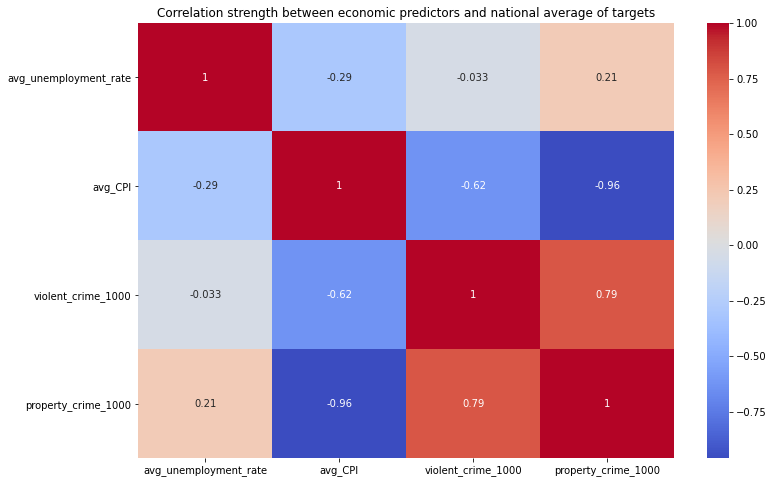

In [33]:
plt.figure(figsize=(12,8))
plt.title('Correlation strength between economic predictors and national average of targets')
sns.heatmap(corr,annot=True,cmap='coolwarm');

A few interesting correlative interactions to note:
* Perhaps contrary to intuition, our targets appear to be negatively correlated with CPI (especially `property_crime_1000`. The interpetation here is that as CPI grows, property crime decreases.
* `property_crime_1000` is weakly positively correlated with average unemployment rate. As the unemployment rate increases, we'd expect property crime rates to grow weakly in response.
* `violent_crime_1000` is not at all correlated with the average unemployment rate, but it is moderately negatively correlated with the average CPI. As CPI increases, we'd expect violent crime rates to decline.

---

## EDA Conclusions

* Growth in population invariably reduces the crime rates across categories in states.
* In the observed data, virtually none of the states' timeplots for `violent_crime_1000` or `property_crime_1000` exhibit stationarity.
    * A little over 80% of the states' crime rates exhibit stationarity if first-differenced
        * 'AZ', 'IL', 'LA', 'MI', 'NJ', 'OH', 'SC', 'TX', 'WA' are the states with non-stationary first-differenced violent crime rates
        * 'AL', 'IL', 'MN', 'MO', 'NY', 'OH', 'WV', 'WI' have non-stationarty first-differenced property crime rates
    * A little over 90% of the states' crime rates exhibit stationarity if second-differenced
        * 'IN', 'MI', 'OR' are the states with non-stationary second-differenced violent crime
        * 'MI', 'PA', 'TN', 'WV' are the states with non-stationary second-differenced property crime
* Except for **unemployment rate** and **property crime rates** (which are weakly positively correlated), the targets and economic variables are negatively correlated with one another.